In [2]:
%%shell
(cd samples/hellojpa && mvn --quiet clean package )

In [72]:
%%shell
docker start H2-JPADemo || docker run --quiet --detach --rm --name=H2-JPADemo \
    -e PUID=$UID -e PGID=$GID \
    -e H2_ARGS="-tcp -tcpAllowOthers -ifNotExists" \
    -p 9092:9092 \
    -v h2-data:/opt/h2-data \
    brunoe/docker-database-h2:develop

H2-JPADemo


In [3]:
%jars samples/hellojpa/target/*-SNAPSHOT-jar-with-dependencies.jar

import jakarta.persistence.*;
import fr.univtln.bruno.demos.jpa.hello.DatabaseManager;
System.setProperty("jakarta.persistence.jdbc.url","jdbc:h2:tcp://host.docker.internal/hellojpa-db");

try (EntityManager entityManager = DatabaseManager.ENTITY_MANAGER_FACTORY.createEntityManager()) { }

19:22:37.336 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.url with system property jakarta.persistence.jdbc.url
19:22:37.339 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.user with system property jakarta.persistence.jdbc.user
19:22:37.339 INFO  f.u.b.d.jpa.hello.DatabaseManager - Override JPA config jakarta.persistence.jdbc.password with system property jakarta.persistence.jdbc.password
19:22:38.881 INFO  com.mchange.v2.log.MLog - MLog clients using slf4j logging.
19:22:39.097 INFO  SQL dialect - HHH000400: Using dialect: org.hibernate.dialect.H2Dialect


In [4]:
import org.slf4j.Logger;
import org.slf4j.LoggerFactory;

Logger log = LoggerFactory.getLogger("Notebook");

# Les associations

# Les relations entre entités

## OneToOne

Parfois, la modélisation orientée objet conduit à utiliser deux classes en relation 1-1 mais que l'on souhaite associer à une seule relation.

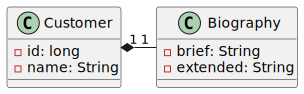

In [6]:
%%plantUML
@startuml
class Biography {
    - brief: String
    - extended: String
}
class Customer {
    - id: long
    - name: String
}

Customer "1" *-right- "1" Biography
@enduml

Pour cela JPA propose des annotations spécifiques :

[@Embeddable](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/embeddable) indique les membres de cette classe java peuvent être persistés comme des attributs de la classe qui l'utilise.

[@Embedded](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/embedded) indique qu'un membre annoté `@embeddable` doit être intégré dans la relation.

A noter qu'il existe aussi [@ElementCollection](https://jakarta.ee/specifications/persistence/3.1/apidocs/jakarta.persistence/jakarta/persistence/elementcollection) permet une association très simple et limitée de type 1-N sans avoir besoin de définir une nouvelle entité entre une classe et une collection d'objets embeddables.

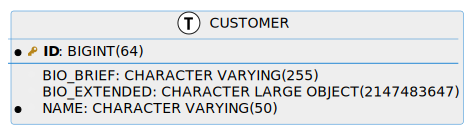

In [9]:
%%rdbmsSchema jdbc:h2:tcp://host.docker.internal/hellojpa-db dba secret EX_BIOGRAPHY
%

In [10]:
%%javasrcClassByName Biography
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_biography/Biography.java

```Java
@Embeddable
@Builder
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@AllArgsConstructor
public class Biography {

    @Column(name = "BIO_BRIEF")
    private String brief;

    @Lob
    @Column(name = "BIO_EXTENDED")
    private String extended;
}
```

In [11]:
%%javasrcClassByName Customer
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_biography/Customer.java

```Java
@Entity
@Data
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "CUSTOMER", schema = "ex_biography")
public class Customer {

    @Id
    @GeneratedValue
    private long id;

    @Column(length = 50, nullable = false)
    @NonNull
    private String name;

    @Embedded
    private Biography biography;
}
```

In [12]:
import fr.univtln.bruno.demos.jpa.hello.samples.ex_biography.*;

try (EntityManager entityManager = DatabaseManager
                .ENTITY_MANAGER_FACTORY.createEntityManager()) {
            entityManager.getTransaction().begin();
            Customer customer = Customer.of("Jim");
            customer.setBiography(Biography.builder().brief("bla").extended("bla bla").build());
            entityManager.persist(customer);
            entityManager.getTransaction().commit();
        }

## One to Many

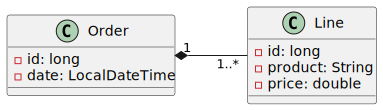

In [14]:
%%plantUML
@startuml
class Order {
    - id: long
    - date: LocalDateTime
}
class Line {
    - id: long
    - product: String
    - price: double
}

Order "1" *-r- "1..*" Line :"         "
@enduml

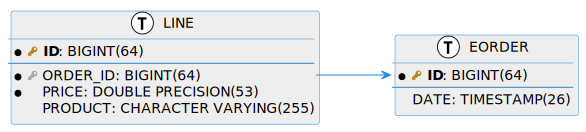

In [15]:
%%rdbmsSchema jdbc:h2:tcp://host.docker.internal/hellojpa-db dba secret EX_ONE_TO_MANY_A
%

In [16]:
%%javasrcClassByName Order
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_associations/ex_onetomanyA/Order.java

```Java
@Entity
@Data
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "EORDER", schema = "EX_ONE_TO_MANY_A")
public class Order {

    @Id
    @GeneratedValue(strategy = GenerationType.SEQUENCE)
    private long id;

    private LocalDateTime date = LocalDateTime.now();

    @OneToMany(mappedBy = "order", cascade = { CascadeType.PERSIST, CascadeType.REMOVE }, orphanRemoval = true)
    private List<Line> lines = new ArrayList<>();

    public Order addLine(Line line) {
        line.setOrder(this);
        lines.add(line);
        return this;
    }

    public Order removeLine(Line line) {
        line.setOrder(this);
        lines.remove(line);
        return this;
    }
}
```

In [17]:
%%javasrcClassByName Line
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_associations/ex_onetomanyA/Line.java

```Java
@Entity
@Data
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "LINE", schema = "EX_ONE_TO_MANY_A")
public class Line {

    @Id
    @GeneratedValue(strategy = GenerationType.SEQUENCE)
    private long id;

    @NonNull
    private String product;

    @NonNull
    private double price;

    @ManyToOne
    @JoinColumn(nullable = false)
    @Setter
    @ToString.Exclude
    private Order order;
}
```

## Many to Many

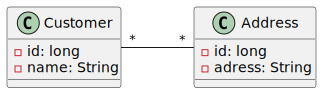

In [19]:
%%plantUML
@startuml
class Customer {
    - id: long
    - name: String
}
class Address {
    - id: long
    - adress: String
}

Customer "*" -right- "*" Address :"         "
@enduml

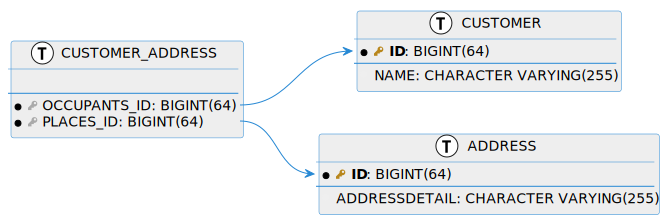

In [20]:
%%rdbmsSchema jdbc:h2:tcp://host.docker.internal/hellojpa-db dba secret EX_MANY_TO_MANY
%

In [21]:
%%javasrcClassByName Customer
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_associations/ex_manytomany/Customer.java

```Java
@Entity
@Data
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "CUSTOMER", schema = "EX_MANY_TO_MANY")
public class Customer {

    @Id
    @GeneratedValue
    private long id;

    @NonNull
    private String name;

    @ManyToMany
    @ToString.Exclude
    @JoinTable(schema = "EX_MANY_TO_MANY")
    private List<Address> places = new ArrayList<>();
}
```

In [22]:
%%javasrcClassByName Address
samples/hellojpa/src/main/java/fr/univtln/bruno/demos/jpa/hello/samples/ex_associations/ex_manytomany/Address.java

```Java
@Entity
@Data
@RequiredArgsConstructor(staticName = "of")
@NoArgsConstructor(access = AccessLevel.PROTECTED)
@Table(name = "ADDRESS", schema = "EX_MANY_TO_MANY")
public class Address {

    @Id
    @GeneratedValue
    private long id;

    @NonNull
    private String addressDetail;

    @ManyToMany(mappedBy = "places")
    @ToString.Exclude
    private List<Customer> occupants;
}
```